# Gradient Descent and its Generalizations


## Learning Goal

The goal of this notebook is to gain intuition for various gradient descent methods by visualizing and applying these methods to some simple two-dimensional surfaces. Methods studied include ordinary gradient descent, gradient descent with momentum, NAG, RMSProp, and ADAM. This notebook follows Notebook 2 and Section IV from the [ML Review](http://physics.bu.edu/~pankajm/MLnotebooks.html) by Mehta et al.


## Overview

In this notebook, we will visualize what different gradient descent methods are doing using some simple surfaces. From the onset, we emphasize that doing gradient descent on the surfaces is different from performing gradient descent on a loss function in Machine Learning (ML). The reason is that in ML not only do we want to find good minima, we want to find good minima that generalize well to new data. Despite this crucial difference, we can still build intuition about gradient descent methods by applying them to simple surfaces (for a useful blog post, see [here](http://ruder.io/optimizing-gradient-descent/)).

## Surfaces

We will consider three simple surfaces: 

* a quadratic minimum of the form 

    $$z(x,y)=ax^2+by^2,$$ 

* a saddle-point of the form 

    $$z(x,y)=ax^2-by^2,$$ 

* and [Beale's Function](https://en.wikipedia.org/wiki/Test_functions_for_optimization):

    $$z(x,y) = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2.$$

Additionally, you may explore

* [Rosenbrock's Function](https://en.wikipedia.org/wiki/Test_functions_for_optimization) which has a global minimum at (x,y) = (1,1):

$$z(x,y) = (1-x)^2 + 100(y-x^2)^2,$$

* and [Himmelblau's Function](https://en.wikipedia.org/wiki/Test_functions_for_optimization) which has four degenerate minima and a local maximum between them:

$$z(x,y) = (x^2+y-11)^2 + (x+y^2-7)^2,$$

The last three are non-convex functions often used to test optimization problems. These surfaces can be plotted using the cells below. 


In [1]:
#This cell sets up basic plotting functions we will use to visualize the gradient descent routines.

#Make plots interactive
%matplotlib notebook

#Make plots static
#%matplotlib inline

#Make 3D plots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import HTML
from matplotlib.colors import LogNorm

#Import Numpy
import numpy as np

#Define function for plotting 

def plot_surface(x, y, z, azim=-60, elev=40, dist=10, cmap="jet"):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plot_args = {'rstride': 1, 'cstride': 1, 'cmap':cmap,
             'linewidth': 20, 'antialiased': True,
             'vmin': -2, 'vmax': 2}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist=dist
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-2, 2)
    
    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;


def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):

    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)
    
    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)
    
    return ax;


def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2, plot_marker=False):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    if plot_marker:
        ax.plot(xs[-1],ys[-1], color+'>', markersize=10)
    return ax;

In [2]:
#DEFINE SURFACES WE WILL WORK WITH

#Define monkey saddle and gradient
def monkey_saddle(x,y):
    return x**3 - 3*x*y**2

def grad_monkey_saddle(params):
    x=params[0]
    y=params[1]
    grad_x= 3*x**2-3*y**2
    grad_y= -6*x*y
    return [grad_x,grad_y]

#Define saddle surface

def saddle_surface(x,y,a=1,b=1):
    return a*x**2-b*y**2

def grad_saddle_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= a*x
    grad_y= -1*b*y
    return [grad_x,grad_y]


# Define minima_surface

def minima_surface(x,y,a=1,b=1):
    return a*x**2+b*y**2-1

def grad_minima_surface(params,a=1,b=1):
    x=params[0]
    y=params[1]
    grad_x= 2*a*x
    grad_y= 2*b*y
    return [grad_x,grad_y]


def beales_function(x,y):
    return (1.5-x+x*y)**2 + (2.25-x+x*y**2)**2 + (2.625-x+x*y**3)**2
  

def grad_beales_function(params):
    x=params[0]
    y=params[1]
    grad_x=2*(1.5-x+x*y)*(-1+y)+2*(2.25-x+x*y**2)*(-1+y**2)+2*(2.625-x+x*y**3)*(-1+y**3)
    grad_y=2*(1.5-x+x*y)*x+4*(2.25-x+x*y**2)*x*y+6*(2.625-x+x*y**3)*x*y**2
    return [grad_x,grad_y]

def contour_beales_function():
    #plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.1), np.arange(-4.5, 4.5, 0.1))
    fig, ax = plt.subplots(figsize=(10, 6))
    z=beales_function(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(3,0.5, 'r*', markersize=18)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    
    return fig,ax
    
    
    
    
#Make plots of surfaces
plt.close() # closes previous plots
x, y = np.mgrid[-1:1:31j, -1:1:31j]

<IPython.core.display.Javascript object>


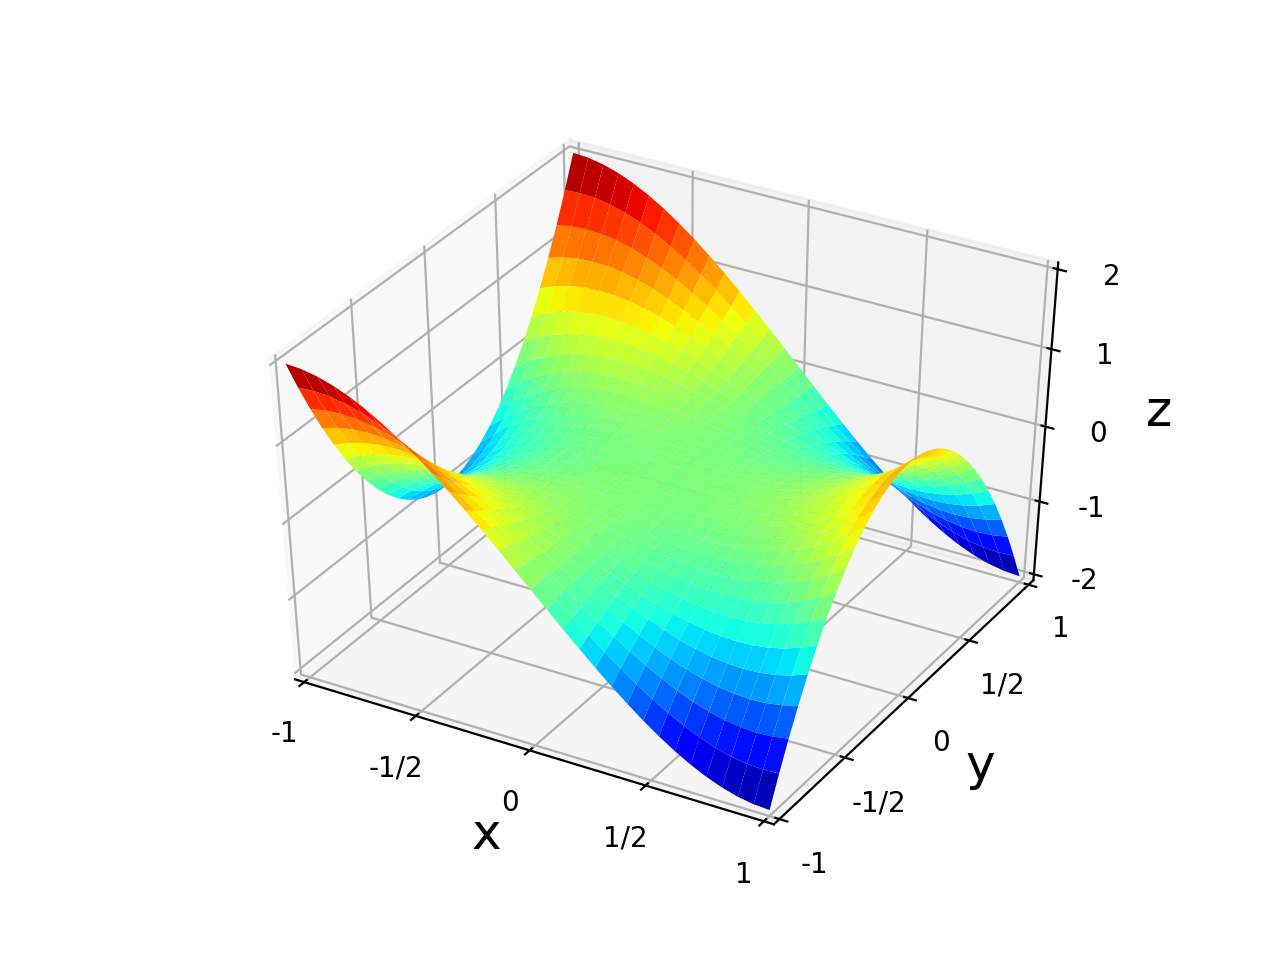

In [3]:
fig1,ax1=plot_surface(x,y,monkey_saddle(x,y))
plt.show()

<IPython.core.display.Javascript object>


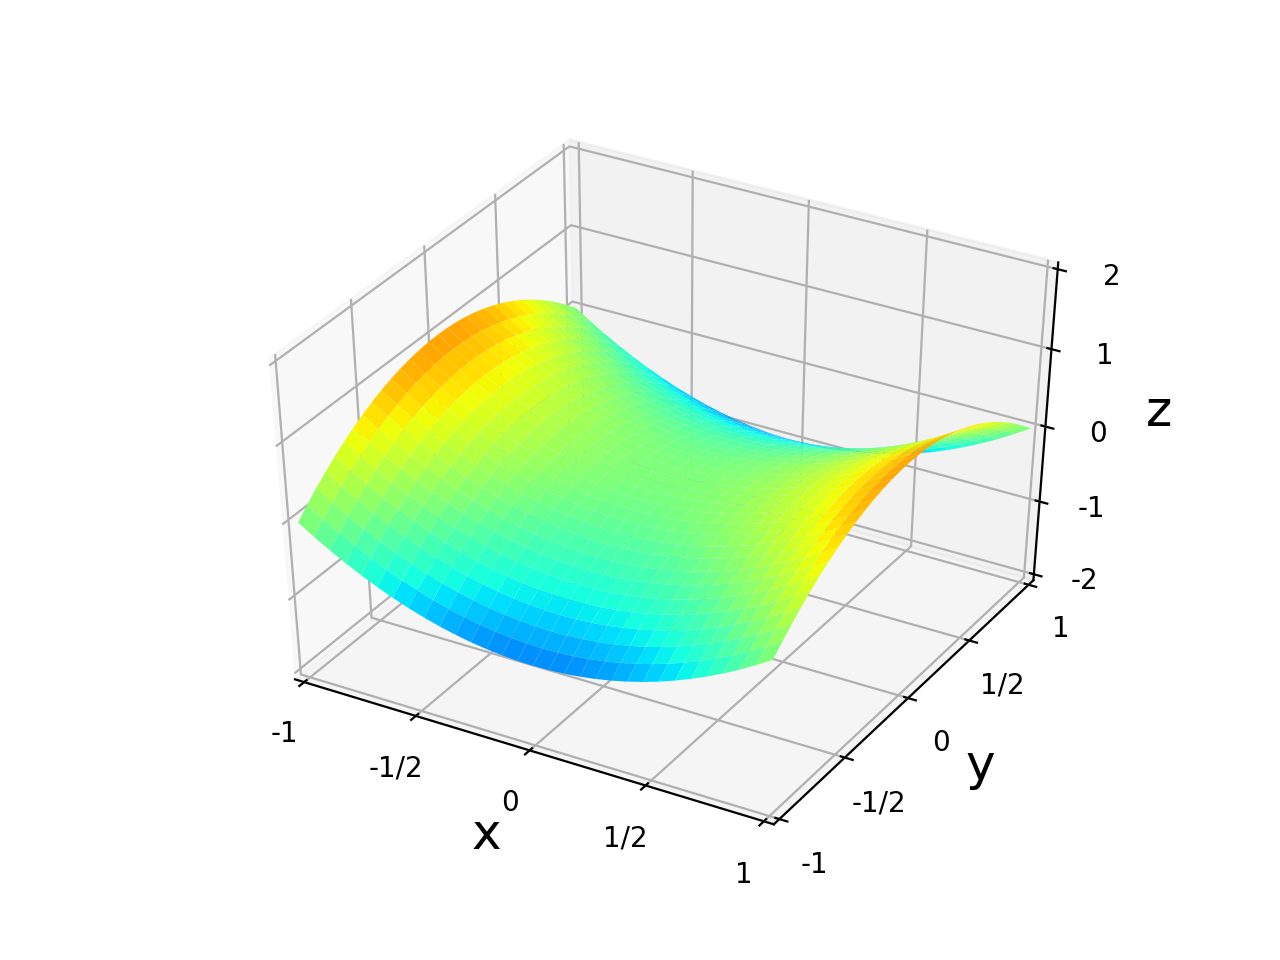

In [4]:
fig2,ax2=plot_surface(x,y,saddle_surface(x,y))
plt.show()

<IPython.core.display.Javascript object>


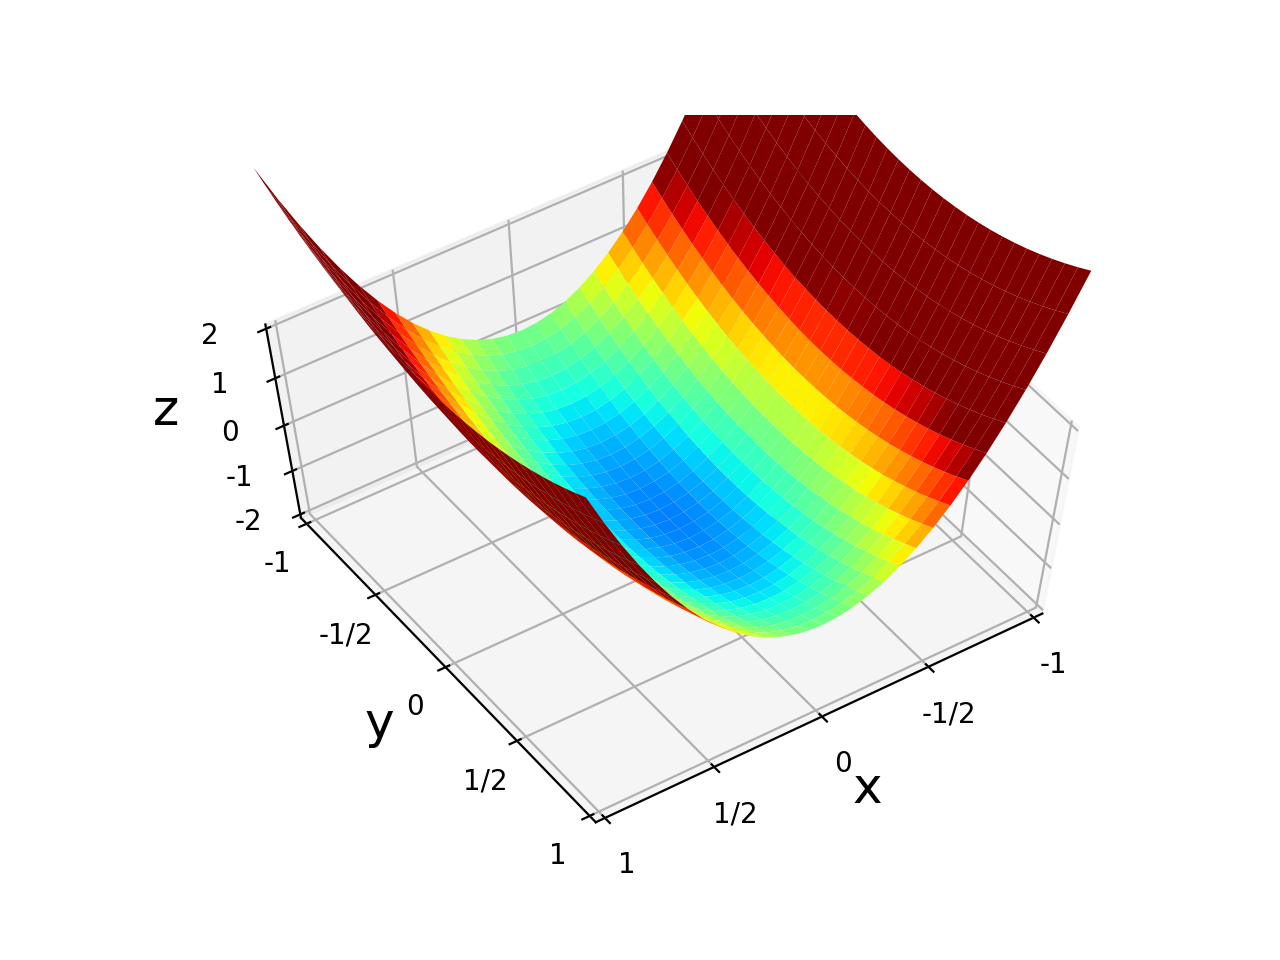

In [6]:
fig3,ax3=plot_surface(x,y,minima_surface(x,y,5),0)
plt.show()

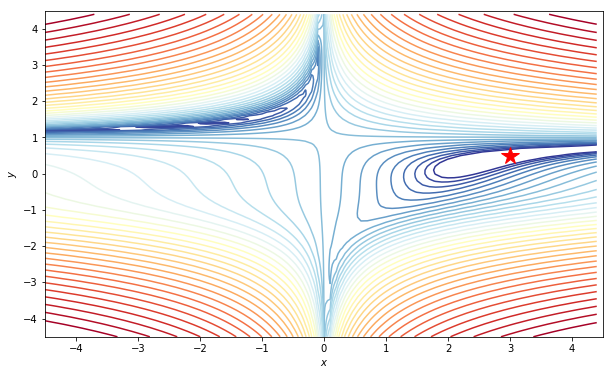

In [7]:
#Make plots static
%matplotlib inline

#Contour plot of Beale's Function
fig4,ax4 = contour_beales_function()
plt.show()

## Gradient Descent *with* and *without* Momentum

We want to visualize various gradient descent algorithms used in machine learning. We will be especially interested in trying to understand how various hyperparameters -- especially the learning rate -- affect our performance. Here, we confine ourselves primarily to looking at the performance in the absence of noise. However, **we encourage the reader to experiment with playing with the noise strength below and seeing what differences introducing stochasticity makes.** 

Throughout, we denote the parameters by $\theta$ and the energy function we are trying to minimize by $E(\theta)$.

### Gradient Descent

We start by considering a simple gradient descent method. In this method,
we will take steps in the direction of the local gradient. Given some parameters $\theta$, we adjust the parameters at each iteration so that

$$\theta_{t+1}= \theta_t - \alpha_t \nabla_\theta E(\theta),$$

where we have introduced the learning rate/step size $\alpha_t$ that controls how large a step we take. In general, the algorithm is extremely sensitive to the choice of $\alpha_t$. If $\alpha_t$ is too large, then one can wildly oscillate around a minimum, and miss important structure at small scales. This problem is amplified if our gradient computations are noisy and inexact (as is often the case in machine learning applications). If $\alpha_t$ is too small, then the learning/minimization procedure becomes extremely slow. This raises the natural question: <i> What sets the natural scale for the learning rate and how can we adaptively choose it?</i> 


### Gradient Descent with Momentum

One problem with gradient descent is that it has no memory of where the "ball rolling down the hill" comes from. This can be an issue when there are many shallow minima in our landscape. If we make an analogy with a ball rolling down a hill, the lack of memory is equivalent to having no inertia or momentum (i.e. completely overdamped dynamics). Without momentum, the ball has no kinetic energy and cannot climb out of shallow minima. 

Momentum becomes especially important when we start thinking about stochastic gradient descent with noisy, stochastic estimates of the gradient. In this case, we should remember where we were coming from and not react drastically to each new update.



Inspired by this, we can add a memory or momentum term to the stochastic gradient descent term above:

$$
\rho_{t}=\gamma \rho_{t-1}+\alpha_{t}\nabla_\theta E(\theta_t),\\
\theta_{t+1}= \theta_t - \rho_{t},
$$

with $0\le \gamma < 1$ called the momentum parameter. When $\gamma=0$, this reduces to ordinary gradient descent, and increasing $\gamma$ increases the inertial contribution to the gradient. From the equations above, we can see that typical memory lifetimes of the gradient is given by $(1-\gamma)^{-1}$. For $\gamma=0$ as in gradient descent, the lifetime is just one step. For $\gamma=0.9$, we typically remember a gradient for ten steps. We will call this gradient descent with classical momentum or GDM for short.

A final widely used variant of gradient descent with momentum is called the Nesterov Accelerated Gradient (NAG). In NAG, rather than calculating the gradient at the current position, one calculates the gradient at the position momentum will carry us to, at time $t+1$, namely, $\theta_t -\gamma \rho_{t-1}$. Thus, the update becomes

$$
\rho_{t}=\gamma \rho_{t-1}+\alpha_{t}\nabla_\theta E(\theta_t-\gamma \rho_{t-1})\\
\theta_{t+1}= \theta_t - \rho_{t}
$$


**In the following, you have to write three routines, one for `gd`, `gd_with_mom`, and `NAG`.** 

In [16]:
#####################################################################
# simple Gradient Descent, Gradient Descent with Momentum, and NAG. #
#####################################################################

"""
grad: function object
    function which computes the gradient at a position [x,y] of the surface.
init: list
    initial parameters [x,y] to start the descent from.
n_epochs: int
    number of iterations for the algorithm. Default is 1000.
alpha: double
    learning rate / stepsize parameter. Default is 10**-4. 
gamma: double (0.0 <= gamma < 1.0)
    momentum parameter: 
noise_strength: double
    defines overall scale of noise, as in `noise_strength * np.random.randn(params.size)`. Default is 0.0.

"""


def GD(grad, init, N_steps=1000, alpha=1E-4, noise_strength=0):
    params = np.array(init)
    param_traj = np.zeros([N_steps+1,2])
    param_traj[0] = init
    rho = 0.0
    for j in range(N_steps):
        noise = noise_strength*np.random.randn(params.size)
        rho = alpha*(np.array(grad(params)) + noise)
        params = params - rho
        param_traj[j+1] = params
    return param_traj


def GDM(grad, init, N_steps=5000, alpha=1E-4, gamma=0.9, noise_strength=0):
    params = np.array(init)
    param_traj = np.zeros([N_steps+1,2])
    param_traj[0] = init
    rho = 0.0
    for j in range(N_steps):
        noise = noise_strength*np.random.randn(params.size)
        rho = gamma*rho + alpha*(np.array(grad(params)) + noise)
        params = params-rho
        param_traj[j+1] = params
    return param_traj

def NAG(grad, init, N_steps=5000, alpha=1E-4, gamma=0.9, noise_strength=0):
    params = np.array(init)
    param_traj = np.zeros([N_steps+1,2])
    param_traj[0] = init
    rho = 0.0
    for j in range(N_steps):
        noise = noise_strength*np.random.randn(params.size)
        params_nesterov = params-gamma*rho
        rho = gamma*rho + alpha*(np.array(grad(params_nesterov)) + noise)
        params = params - rho
        param_traj[j+1] = params
    return param_traj

## Experiments with GD, GDM, and NAG

Before introducing more complicated algorithms, let us experiment with these methods to gain some intuition.

Let us look at the dependence of GD on learning rate in a simple quadratic minimum of the form $z=ax^2+by^2-1$. Make  plots below for $\alpha=0.1,0.5,1,1.01$ and $a=1$ and $b=1$. **NB:** to do this, you would have to add additional arguments to the function `GD` above in order to pass the new values of `a` and `b`; otherwise the default values `a=1` and `b=1` will be used by the gradient.

* What are the qualitatively different behaviors that arise as $\alpha$ is increased?
* What does this tell us about the importance of choosing learning parameters? How do these change if we change $a$ and $b$ above? In particular how does anisotropy change the learning behavior?
* Make similar plots for GDM and NAG? How do the learning rates for these procedures compare with those for GD?
* How do the above result change if we add noise? What happens if we vary the noise strength?

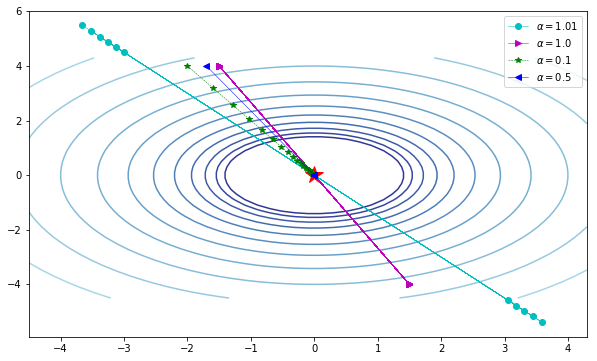

In [17]:
# Investigate effect of learning rate in GD

a,b = 1.0,1.0
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
z=np.abs(minima_surface(x,y,a,b))

plt.close()
fig, ax = plt.subplots(figsize=(10, 6))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)

#initial point
init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]

alpha1=0.1
alpha2=0.5
alpha3=1.0
alpha4=1.01

gd_1=GD(grad_minima_surface,init1, N_steps=100, alpha=alpha1)
gd_2=GD(grad_minima_surface,init2, N_steps=100, alpha=alpha2)
gd_3=GD(grad_minima_surface,init3, N_steps=100, alpha=alpha3)
gd_4=GD(grad_minima_surface,init4, N_steps=10, alpha=alpha4)

overlay_trajectory_contour(ax,gd_4,'$\\alpha={}$'.format(alpha4),'c-o' , lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\\alpha={}$'.format(alpha3),'m->' , lw=0.5)
overlay_trajectory_contour(ax,gd_1,'$\\alpha={}$'.format(alpha1),'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\\alpha={}$'.format(alpha2),'b-<' , lw=0.5)


plt.legend()
plt.show()


## Algorithms that Estimate the Second Moment of the Gradient

Stochastic gradient descent, with and without momentum, can benefit by using parameter-dependent gradient updates. This is because steps in different directions need to be taken at a different pace. This can be accomplished by defning an effective, parameter-dependent gradient update. 

As discussed in class in the context of Newton's method, this presents a number of dilemmas. The learning rate is limited by the steepest direction which can change depending on where in the landscape we are. To circumvent this problem, ideally our algorithm would take large steps in shallow, flat directions and small steps in steep, narrow directions. Second-order methods accomplish this by calculating or approximating the Hessian and normalizing the learning rate by the curvature. However, this is very computationally expensive for extremely large models.  Ideally, we would like to be able to adaptively change our step size to match the landscape without paying the steep computational price of calculating or approximating Hessians.

Recently, a number of methods have been introduced that accomplish this by tracking not only the gradient but also the second moment of the gradient. These methods include AdaGrad, AdaDelta, RMS-Prop, and ADAM. Here, we discuss the latter of these two as representatives of this class of algorithms.

### RMS prop (Root-Mean-Square propagation)

In RMS prop (Root-Mean-Square propagation), in addition to keeping a running average of the first moment of the gradient, we also keep track of the second moment through a moving average. The update rule for RMS prop is given by

$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) \\
\mathbf{v}_t =\beta \mathbf{v}_{t-1} +(1-\beta)\mathbf{g}_t^2 \nonumber \\
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t - \alpha_t { \mathbf{g}_t \over \sqrt{\mathbf{v}_t +\epsilon}}, \nonumber
$$

where $\beta$ controls the averaging time of the second moment and is typically taken to be about $\beta=0.9$, $\alpha_t$ is a learning rate typically chosen to be $10^{-3}$, and $\epsilon\sim 10^{-8}$ is a small regularization constant to prevent divergences. It is clear from this formula that the learning rate is reduced in directions where the norm of the gradient is consistently large. This greatly speeds up the convergence by allowing us to use a larger learning rate for flat directions.

### ADAM

A related algorithm is given by the ADAM optimizer. In ADAM, we keep a running average of both the first and second moment of the gradient and use this information to adaptively change the learning rate for different parameters. In addition to keeping a running average of the first and second moments of the gradient, ADAM performs an additional bias correction to account for the fact that we are estimating the first two moments of the gradient using a running average (denoted by the hats in the update rule below). The update rule for ADAM is given by (*with multiplication and division understood to be element wise operations*)

$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) \\
\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1-\beta_1) \mathbf{g}_t \nonumber \\
\mathbf{v}_t =\beta_2 \mathbf{v}_{t-1} +(1-\beta_2)\mathbf{g}_t^2 \nonumber \\
\hat{\mathbf{m}}_t={\mathbf{m}_t \over 1-\beta_1^t} \nonumber \\
\hat{\mathbf{v}}_t ={\mathbf{v}_t \over1-\beta_2^t} \nonumber \\
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t - \alpha_t { \hat{\mathbf{m}}_t \over \sqrt{\hat{\mathbf{v}}_t +\epsilon}}, \nonumber 
$$

where $\beta_1$ and $\beta_2$ set the memory lifetime of the first and second moment and are typically take to be $0.9$ and $0.99$ respectively, and $\alpha$ and $\epsilon$ are identical
to RMSprop. Here, $\beta_j^t$ stands for $\beta$ to the power $t$.

**In the following, you have to write routines for RMSProp and ADAM.** 

In [12]:
################################################################################
# Methods that exploit first and second moments of gradient: RMS-PROP and ADAM #
################################################################################

"""
grad: function object
    function which computes the gradient at a position [x,y] of the surface.
init: list
    initial parameters [x,y] to start the descent from.
N_steps: int
    number of iterations for the algorithm. Default is 1000.
alpha: double
    learning rate / stepsize parameter. Default is 10**-4. 
gamma: double (0.0 <= gamma < 1.0)
    momentum parameter: 
beta, beta_1, beta_2: double
    parameters controlling the averaging time of the gradient moments. 
noise_strength: double
    defines overall scale of noise, as in `noise_strength * np.random.randn(params.size)`. Default is 0.0.

"""


def rms_prop(grad, init, N_steps=5000, alpha=1E-3, beta=0.9, epsilon=10**-8, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([N_steps+1,2])
    param_traj[0]=init
    v=0.0;
    for j in range(N_steps):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=beta*v+(1-beta)*g*g
        params= params-alpha*np.divide(g,np.sqrt(v+epsilon))
        param_traj[j+1]=params
    return param_traj
                        
                        
def adam(grad, init, N_steps=5000, alpha=1E-4, beta_1=0.9, beta_2=0.99, epsilon=10**-8, noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([N_steps+1,2])
    param_traj[0]=init
    m=0.0;
    v=0.0;
    for j in range(N_steps):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        m=beta_1*m+(1.0-beta_1)*g
        v=beta_2*v+(1-beta_2)*g*g
        m_hat=m/(1.0-beta_1**(j+1))
        v_hat=v/(1-beta_2**(j+1))
        params=params-alpha*np.divide(m_hat,np.sqrt(v_hat+epsilon))
        param_traj[j+1]=params
    return param_traj

## Experiments with ADAM and RMSprop

In this section, we will experiment with ADAM and RMSprop. To do so, we will use Beale's function (see above) -- a function commonly used in optimization protocols:

$$
f(x,y)=(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2.
$$

This function has a global minimum at $(x,y)=(3,0.5)$. We will use GD, GDM, NAG, RMSprop, and ADAM to find minima starting at different initial conditions.

One of the things you should experiment with is the learning rate and the number of steps, $N_{\mathrm{steps}}$ we take. Initially, we have set $N_{\mathrm{steps}}=10^4$ and the learning rate for ADAM/RMSprop to $\alpha=10^{-3}$ and the learning rate for the remaining methods to $10^{-6}$.

* Examine the plot for these default values by changing the ititial parametesr `init` below (we have provided a set of four interesting cases, but feel free to explore more). What do you see?
* Make a plot when the learning rate of all methods is $\alpha=10^{-6}$? How does your plot change?
* Now set the learning rate for all algorithms to $\alpha=10^{-3}$? What goes wrong? Why?
* Explore what happens if you turn on and vary the noise strength parameter. 

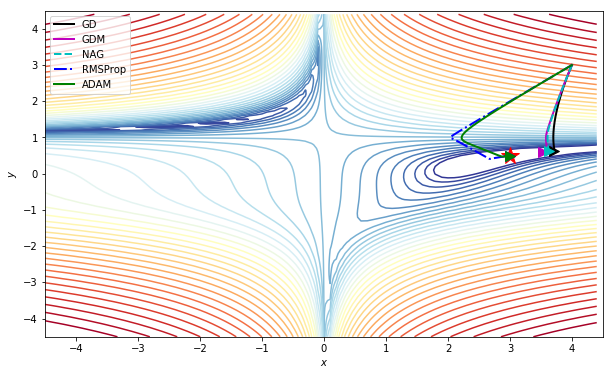

In [13]:
plt.close()
#Make static plot of the results
Nsteps=int(1E+4)
lr_l=1E-3
lr_s=1E-6

init=np.array([4.0,3.0])
#init=np.array([-2.0,-4.0])
#init=np.array([1.5,1.5])
#init=np.array([-1.0,-0.1])

noise_strength=0.0

fig, ax=contour_beales_function()


gd_trajectory       = GD(grad_beales_function, init, 10**5, alpha=lr_s, noise_strength=noise_strength)
gdm_trajectory      = GDM(grad_beales_function, init,10**5, alpha=lr_s, gamma=0.9, noise_strength=noise_strength)
NAG_trajectory      = NAG(grad_beales_function, init, Nsteps, alpha=lr_s, gamma=0.9, noise_strength=noise_strength)
rms_prop_trajectory = rms_prop(grad_beales_function, init, Nsteps, alpha=lr_l, beta=0.9, epsilon=10**-8, noise_strength=noise_strength)
adam_trajectory     = adam(grad_beales_function, init, Nsteps, alpha=lr_l, beta_1=0.9, beta_2=0.99, epsilon=10**-8, noise_strength=noise_strength)


overlay_trajectory_contour(ax,gd_trajectory,      'GD',     'k',   plot_marker=True)
overlay_trajectory_contour(ax,gdm_trajectory,     'GDM',    'm',   plot_marker=True)
overlay_trajectory_contour(ax,NAG_trajectory,     'NAG',    'c--', plot_marker=True)
overlay_trajectory_contour(ax,rms_prop_trajectory,'RMSProp','b-.', plot_marker=True)
overlay_trajectory_contour(ax,adam_trajectory,    'ADAM',   'g',   plot_marker=True)


plt.legend()
plt.show()

## Learning Rate Schedule

Ofte times in Machine Learning, one uses a learning rate schedule. This has a two-fold purpose: (i) ensure that large steps are taken in the beginning of training where fine-tuning is irrelevant; this can be used to speed up the convergence of the algorithms. (ii) stabilize convergence algorithm at the later stages of training. A learning rate schedule is given by a time-dependent learning rate $\alpha_t$. This means that the value of the learning rate $\alpha_t$ changes from one iteration to the next. Typically, this schedule is fixed such that the learning rate/stepsize parameter decreases with increasing number of steps. Common schedules use a logarithmic, power-law, or exponential decay, but one can design mixed schedules, where the learning rate is kept fixed after a fixed amount of iterations. 

**CAVEAT:** if the decay rate of your learning rate schedule is too large, then it may artificially prevent the ML model from learning by suppressing the parameter update (a vanishing learning rate means no update).

* Explain the difference between a learning rate schedule and a parameter-dependent learning rate (like the ones we saw in RMSprop and ADAM.
* Add a learning rate schedule to the `adam` optimizer above
* Explore the effects of using a schedule for all five algorithms: GD, GDM, NAG, RMSprop, ADAM. 